# Statistical Methods in Time Series: ARIMA and SARIMA

**ARIMA**:

📌 In statistics and econometrics, and in particular in time series analysis, an autoregressive integrated moving average (ARIMA) model is a generalization of an autoregressive moving average (ARMA) model. To better comprehend the data or forecast upcoming series points, both of these models are fitted to time series data. ARIMA models are applied in some cases where data show evidence of non-stationarity in the sense of mean.

ARIMA: Autoregressive + Moving Average + Trend Differencing

**SARIMA**:

📌 Seasonal Autoregressive Integrated Moving Average, SARIMA or Seasonal ARIMA, is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component. It adds three new hyperparameters to specify the autoregression (AR), differencing (I) and moving average (MA) for the seasonal component of the series, as well as an additional parameter for the period of the seasonality.

SARIMA: Autoregressive + Moving Average + Trend Differencing + Seasonal Differencing

# Business Problem

📌 Our aim here is to estimate the amount of air pollution (co2) one month later.

# Dataset Story

📌 The carbon dioxide record from Mauna Loa Observatory, known as the “Keeling Curve,” is the world’s longest unbroken record of atmospheric carbon dioxide concentrations. Scientists make atmospheric measurements in remote locations to sample air that is representative of a large volume of Earth’s atmosphere and relatively free from local influences.

Atmospheric CO2 from Continuous Air Samples at Mauna Loa Observatory, Hawaii, U.S.A.
Period of Record: March 1958 - December 2001

# Import Necessary Libraries

In [ ]:
import itertools
import warnings
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 500)
pd.set_option("display.float_format", lambda x: "%.4f" % x)

import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt

warnings.filterwarnings("ignore")

# Import Dataset

In [ ]:
data = sm.datasets.co2.load_pandas()
y = data.data
y.head()

,co2
1958-03-29,316.1000
1958-04-05,317.3000
1958-04-12,317.6000
1958-04-19,317.5000
1958-04-26,316.4000


In [ ]:
# Converting Weekly Data to Monthly Data
y = y['co2'].resample('MS').mean()
y.head()

1958-03-01   316.1000
1958-04-01   317.2000
1958-05-01   317.4333
1958-06-01        NaN
1958-07-01   315.6250
Freq: MS, Name: co2, dtype: float64

# Missing Value Analysis

In [ ]:
y.isnull().sum()

5

In [ ]:
# Filling the Missing Values with the Next Value
y = y.fillna(y.bfill())
y.isnull().sum()

0

# Visualizing the Time Series Simply

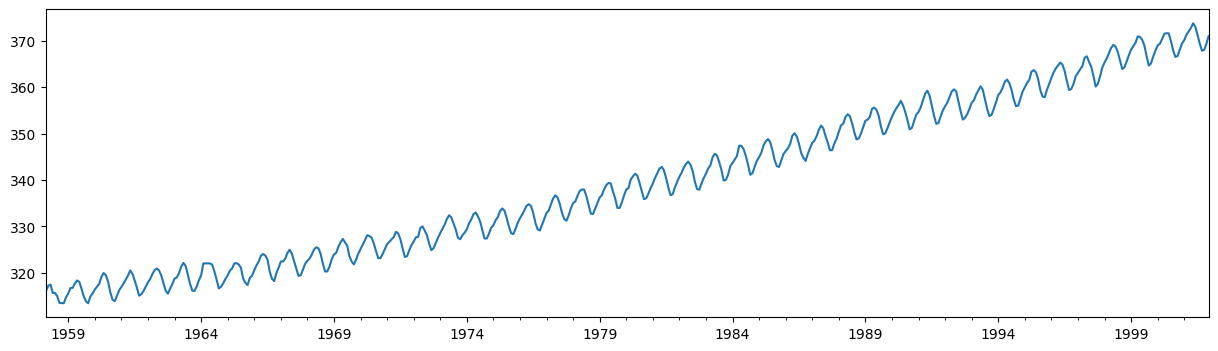

In [ ]:
y.plot(figsize=(15, 4))
plt.show()

# Splitting the Dataset

In [ ]:
# Using Holdut Method ===> Train: 478 Month and Test: 48 Month
train = y[:'1997-12-01']
test = y['1998-01-01':]
print((len(train), len(test)))

(478, 48)


# Time Series Structural Analysis

In [ ]:
def ts_decompose(y, model="additive"):
    
    # Stationary Test: Dickey-Fuller
    # "HO: Non-stationary"
    # "H1: Stationary"
    p_value = sm.tsa.stattools.adfuller(y)[1]
    if p_value < 0.05:
        is_istationary = (F"Result: Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")
    else:
        is_istationary = (F"Result: Non-Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")
    
    result = seasonal_decompose(y, model=model)
    fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(15)

    axes[0].set_title("Decomposition for " + model + " model")
    axes[0].plot(y, 'k', label='Original ' + model)
    axes[0].legend(loc='upper left')

    axes[1].set_title(is_istationary)
    axes[1].plot(result.trend, label='Trend')
    axes[1].legend(loc='upper left')

    axes[2].plot(result.seasonal, 'g', label='Seasonality & Mean: ' + str(round(result.seasonal.mean(), 4)))
    axes[2].legend(loc='upper left')

    axes[3].plot(result.resid, 'r', label='Residuals & Mean: ' + str(round(result.resid.mean(), 4)))
    axes[3].legend(loc='upper left')
    plt.show(block=True)

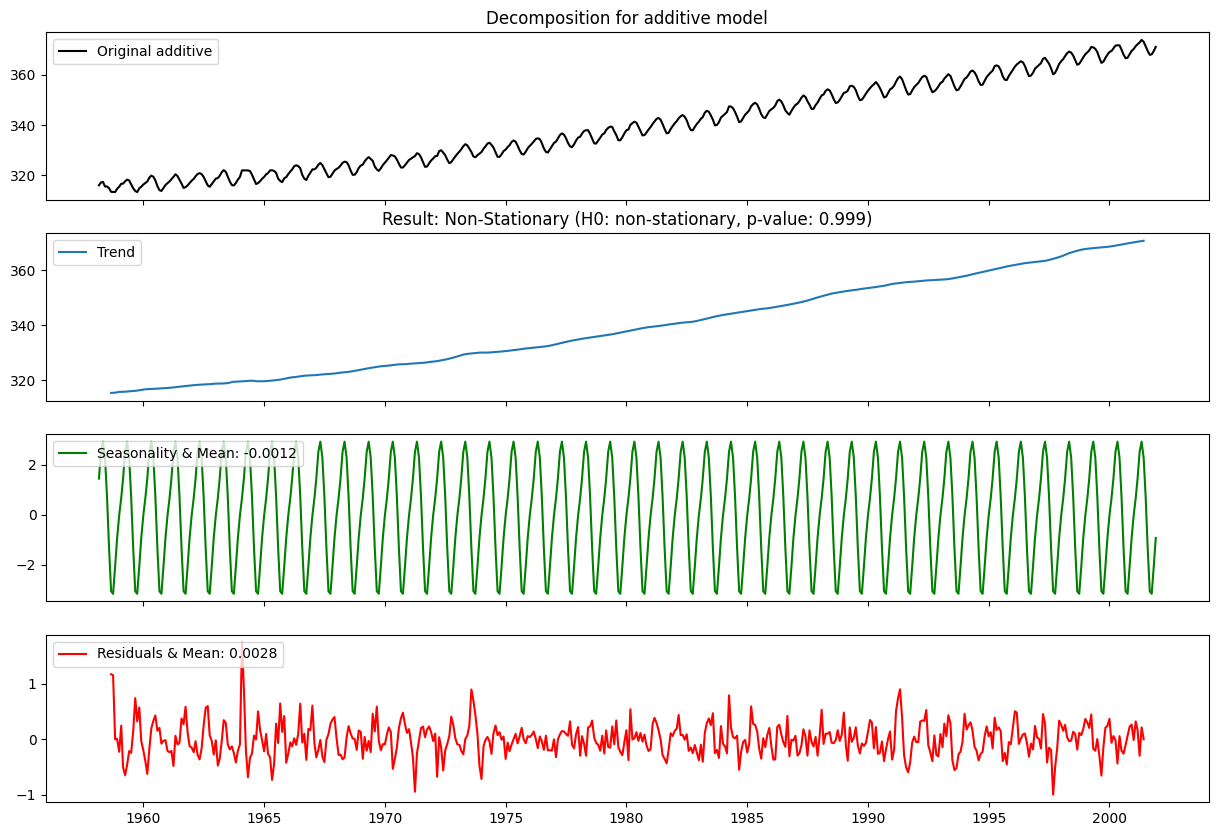

In [ ]:
ts_decompose(y)

# ARIMA(p, d, q): (Autoregressive Integrated Moving Average)

📌 In statistics and econometrics, and in particular in time series analysis, an autoregressive integrated moving average (ARIMA) model is a generalization of an autoregressive moving average (ARMA) model. To better comprehend the data or forecast upcoming series points, both of these models are fitted to time series data. ARIMA models are applied in some cases where data show evidence of non-stationarity in the sense of mean.

## Create a Base Model Using ARIMA

ARIMA: Autoregressive + Moving Average + Trend Differencing

In [ ]:
def plot_model(train, test, y_pred, title):
  mae = mean_absolute_error(test, y_pred)
  train.plot(figsize=(15, 4), legend=True, label="TRAIN", title=f"{title}, MAE: {round(mae, 2)}")
  test.plot(legend=True, label="TEST")
  y_pred.plot(legend=True, label="PREDICTION")
  plt.show()

In [ ]:
def arima_base_model(train, test, p, d, q, step, title="Autoregressive Integrated Moving Average(ARIMA)"):
  arima_model = ARIMA(train, order=(p, d, q)).fit()
  y_pred = arima_model.forecast(step)
  plot_model(train, test, y_pred, title)

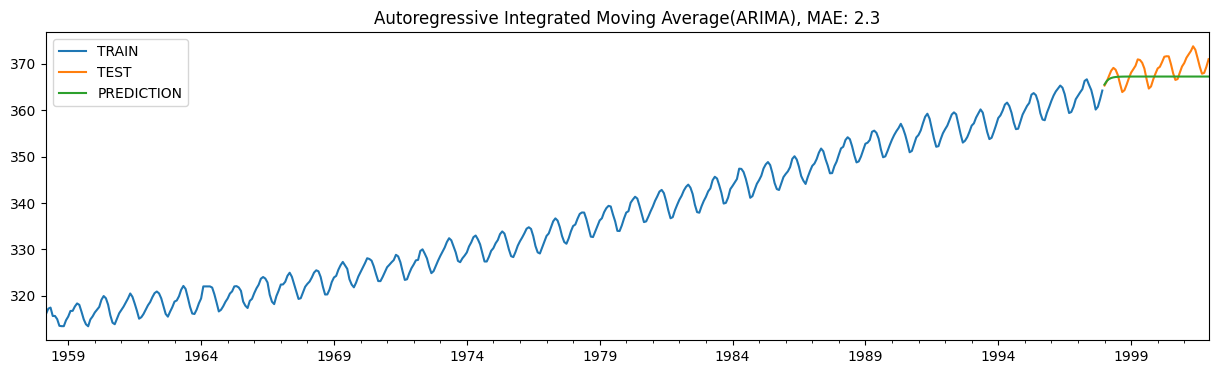

In [ ]:
arima_base_model(train, test, p=1, d=1, q=1, step=48)

## Model Tuning - Autoregressive Integrated Moving Average

Determining Model Grade Based on AIC and BIC Statistics

In [ ]:
def arima_optimizer_aic(train, orders):
    best_aic, best_params = float("inf"), None
    for order in orders:
        try:
            arima_model_result = ARIMA(train, order=order).fit()
            aic = arima_model_result.aic
            if aic < best_aic:
                best_aic, best_params = aic, order
        except:
            continue
    return best_aic, best_params

In [ ]:
def arima_model_tuning_aic(train, test, step, title="Model Tuning - Autoregressive Integrated Moving Average"):
  p = d = q = range(0, 4)
  pdq = list(itertools.product(p, d, q))
  best_aic, best_params = arima_optimizer_aic(train, pdq)
  final_model = ARIMA(train, order=best_params).fit()
  y_pred = final_model.forecast(step)
  plot_model(train, test, y_pred, title)

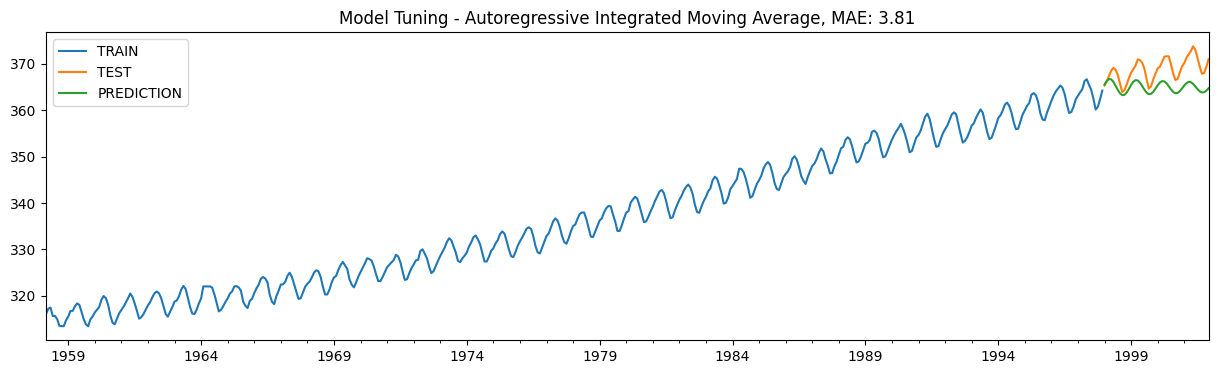

In [ ]:
arima_model_tuning_aic(train, test, step=48)

## Model Tuning - Autoregressive Integrated Moving Average

Determining Model Grade Based on MAE(Mean Absolute Error)

In [ ]:
def arima_optimizer_mae(train, orders, step):
    best_mae, best_params = float("inf"), None
    for order in orders:
        try:
            arima_model_result = ARIMA(train, order=order).fit()
            y_pred = arima_model_result.forecast(step)
            mae = mean_absolute_error(test, y_pred)
            if mae < best_mae:
                best_mae, best_params = mae, order
        except:
            continue
    return best_mae, best_params

In [ ]:
def arima_model_tuning_mae(train, test, step, title="Model Tuning - Autoregressive Integrated Moving Average"):
  p = d = q = range(0, 4)
  pdq = list(itertools.product(p, d, q))
  best_mae, best_params = arima_optimizer_mae(train, pdq, step)
  final_model = ARIMA(train, order=best_params).fit()
  y_pred = final_model.forecast(step)
  plot_model(train, test, y_pred, title)
  return best_mae, best_params

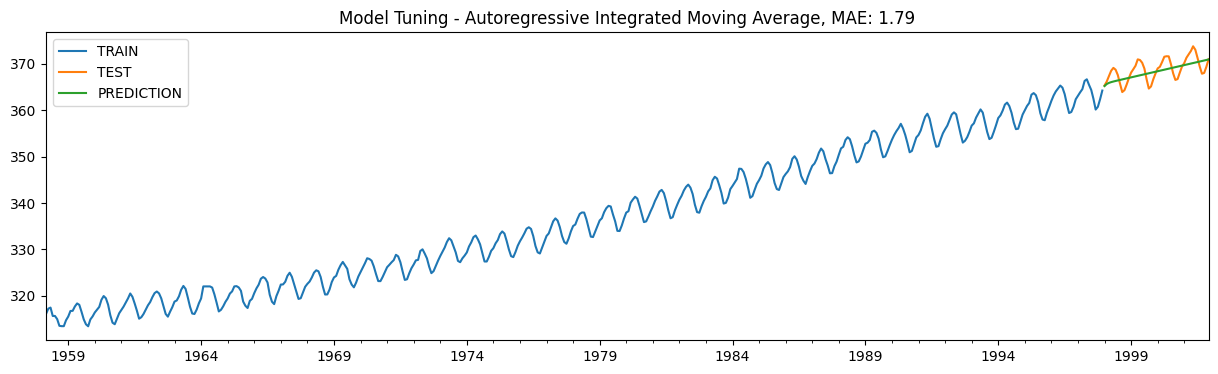

In [ ]:
best_mae, best_params = arima_model_tuning_mae(train, test, step=48)

## ARIMA Final Model(Prediction)

In [ ]:
def arima_final_model(y, best_params, step):
  final_model = ARIMA(y, order=best_params).fit()
  feature_predict = final_model.forecast(step)
  return feature_predict

In [ ]:
arima_final_model(y, best_params, step=6)

2002-01-01   372.1775
2002-02-01   372.8013
2002-03-01   373.1200
2002-04-01   373.3161
2002-05-01   373.4631
2002-06-01   373.5902
Freq: MS, Name: predicted_mean, dtype: float64

# SARIMA(p, d, q): (Seasonal Autoregressive Integrated Moving-Average)

📌 Seasonal Autoregressive Integrated Moving Average, SARIMA or Seasonal ARIMA, is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component. It adds three new hyperparameters to specify the autoregression (AR), differencing (I) and moving average (MA) for the seasonal component of the series, as well as an additional parameter for the period of the seasonality.

## Create a Base Model Using SARIMA

SARIMA: Autoregressive + Moving Average + Trend Differencing + Seasonal Differencing

In [ ]:
def sarima_base_model(train, test, p, d, q, P, D, Q, m, step, title="Seasonal Autoregressive Integrated Moving-Average(SARIMA)"):
  sarima_model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, m)).fit()
  y_pred_test = sarima_model.get_forecast(step)
  y_pred = y_pred_test.predicted_mean
  plot_model(train, test, y_pred, title)

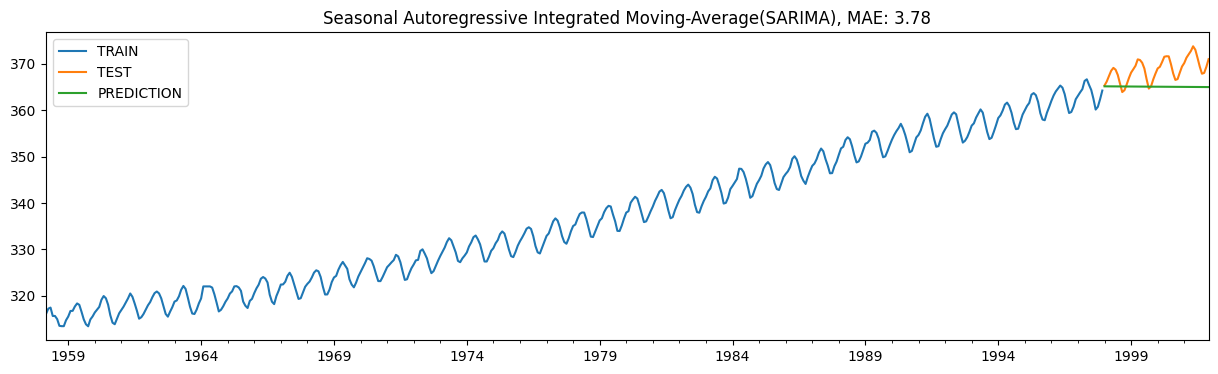

In [ ]:
sarima_base_model(train, test, p=1, d=0, q=1, P=0, D=0, Q=0, m=12, step=48)

## Model Tuning - Seasonal Autoregressive Integrated Moving-Average

Determining Model Grade Based on AIC and BIC Statistics

In [ ]:
def sarima_optimizer_aic(train, pdq, seasonal_pdq):
    best_aic, best_order, best_seasonal_order = float("inf"), None, None
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                sarimax_model_results = SARIMAX(train, order=param, seasonal_order=param_seasonal).fit()
                aic = sarimax_model_results.aic
                if aic < best_aic:
                    best_aic, best_order, best_seasonal_order = aic, param, param_seasonal
            except:
                continue
    return best_order, best_seasonal_order

In [ ]:
def sarima_model_tuning_aic(train, test, step, title="Model Tuning - Seasonal Autoregressive Integrated Moving-Average"):
  p = d = q = range(0, 2)
  pdq = list(itertools.product(p, d, q))
  seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
  best_order, best_seasonal_order = sarima_optimizer_aic(train, pdq, seasonal_pdq)
  final_model = SARIMAX(train, order=(1,0,0), seasonal_order=best_seasonal_order).fit()
  y_pred_test = final_model.get_forecast(step)
  y_pred = y_pred_test.predicted_mean
  plot_model(train, test, y_pred, title)

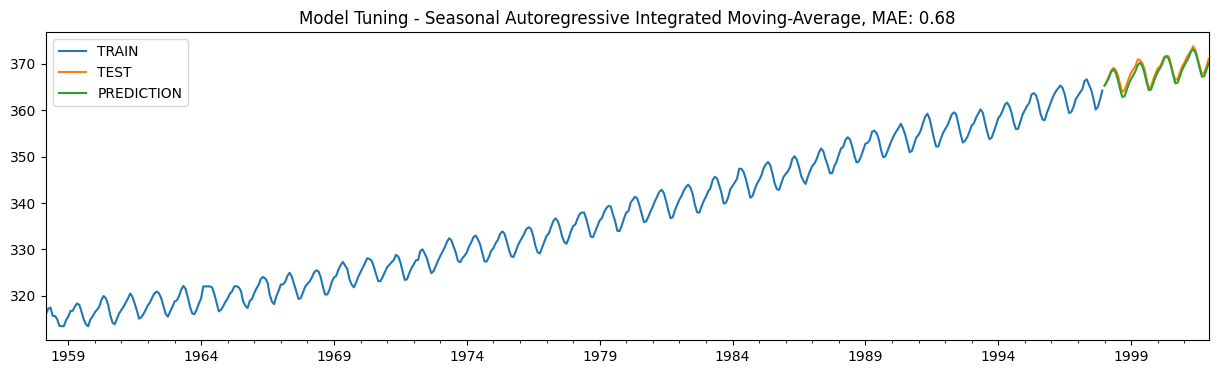

In [ ]:
sarima_model_tuning_aic(train, test, step=48)

## Model Tuning - Seasonal Autoregressive Integrated Moving-Average

Determining Model Grade Based on MAE(Mean Absolute Error)

In [ ]:
def sarima_optimizer_mae(train, pdq, seasonal_pdq, step):
    best_mae, best_order, best_seasonal_order = float("inf"), None, None
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                sarimax_model_results = SARIMAX(train, order=param, seasonal_order=param_seasonal).fit()
                y_pred_test = sarimax_model_results.get_forecast(step)
                y_pred = y_pred_test.predicted_mean
                mae = mean_absolute_error(test, y_pred)
                if mae < best_mae:
                    best_mae, best_order, best_seasonal_order = mae, param, param_seasonal
            except:
                continue
    return best_order, best_seasonal_order

In [ ]:
def sarima_model_tuning_mae(train, test, step, title="Model Tuning - Seasonal Autoregressive Integrated Moving-Average"):
  p = d = q = range(0, 2)
  pdq = list(itertools.product(p, d, q))
  seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
  best_order, best_seasonal_order = sarima_optimizer_mae(train, pdq, seasonal_pdq, step)
  final_model = SARIMAX(train, order=best_order, seasonal_order=best_seasonal_order).fit()
  y_pred_test = final_model.get_forecast(step)
  y_pred = y_pred_test.predicted_mean
  plot_model(train, test, y_pred, title)
  return best_order, best_seasonal_order

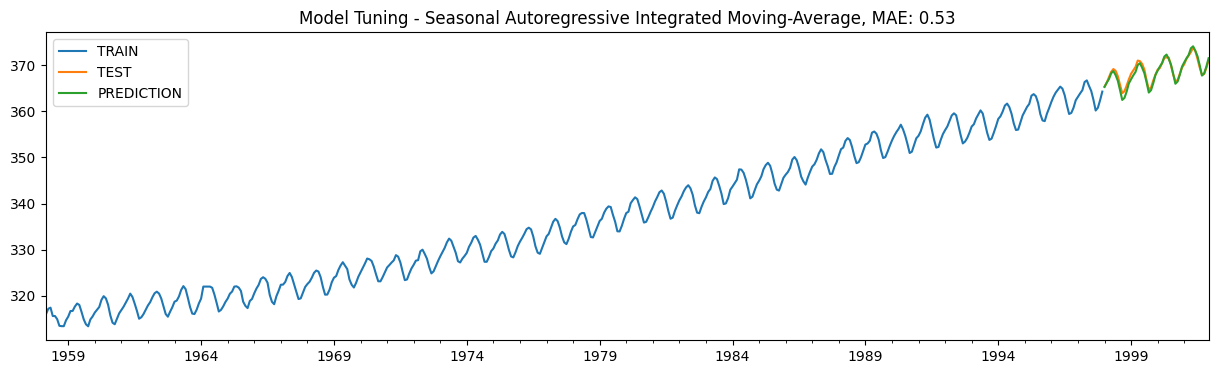

In [ ]:
best_order, best_seasonal_order = sarima_model_tuning_mae(train, test, step=48)

## SARIMA Final Model(Prediction)

In [ ]:
def sarima_final_model(y, best_order, best_seasonal_order, step):
  final_model = SARIMAX(y, order=best_order, seasonal_order=best_seasonal_order).fit()
  feature_predict = final_model.get_forecast(step)
  feature_predict = feature_predict.predicted_mean
  return feature_predict

In [ ]:
sarima_final_model(y, best_order, best_seasonal_order, step=6)

2002-01-01   371.9305
2002-02-01   372.7181
2002-03-01   373.5853
2002-04-01   374.4941
2002-05-01   375.1019
2002-06-01   374.6879
Freq: MS, Name: predicted_mean, dtype: float64